## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)

<hr style="height:1px;border-top:4px solid #FF8200" />

# Chemical Composition in Core-Loss Spectra


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Content

Qunatitative determination of composition in a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt
from scipy.ndimage.filters import gaussian_filter

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.EELS_tools  as eels 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
windows
pyTEM version:  0.6.2019.2


# Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

<IPython.core.display.Javascript object>


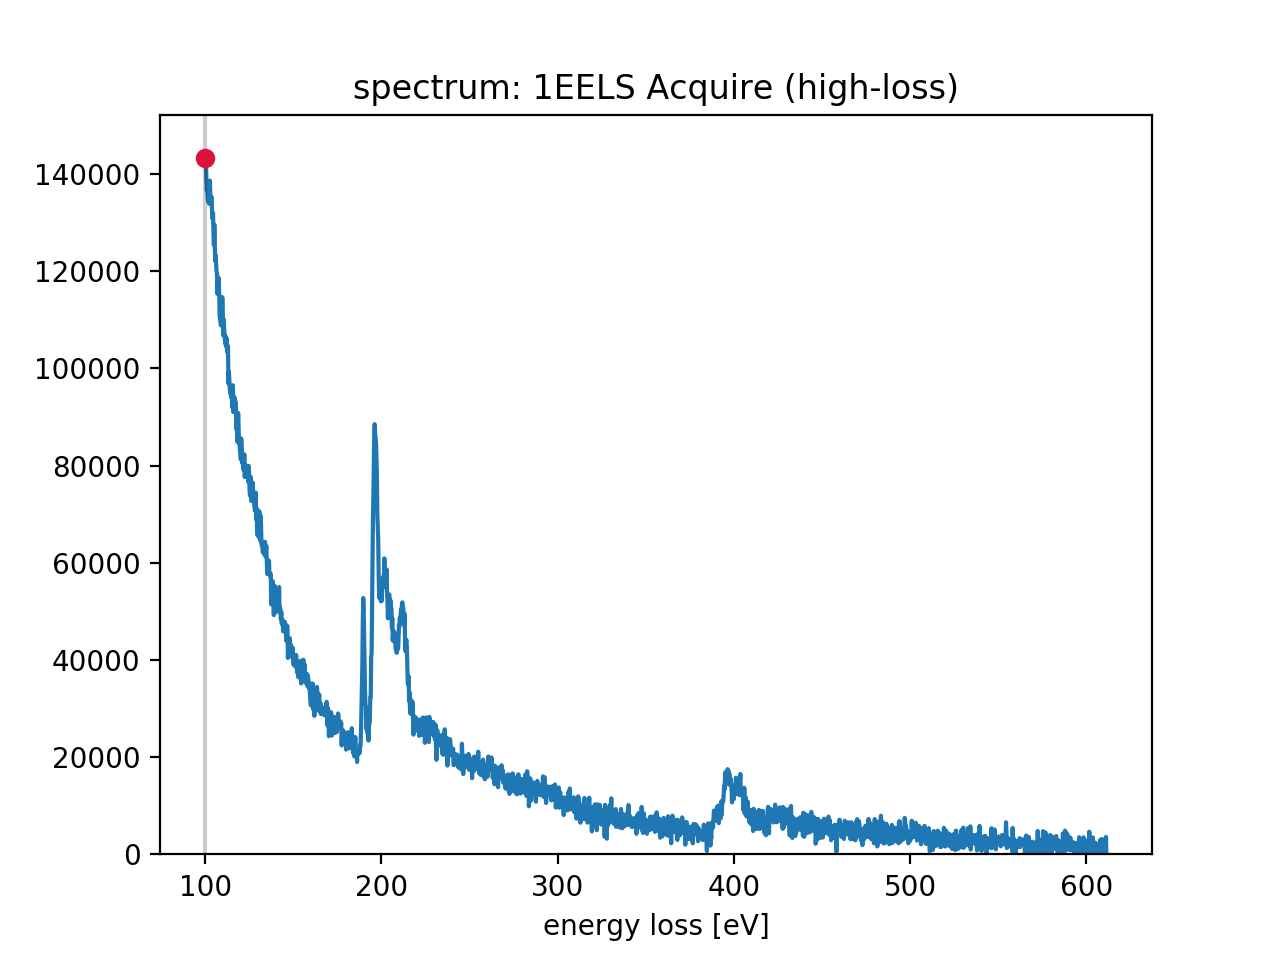

In [2]:
# Load file
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)
energy_scale_orig = tags['energy_scale']


# plot data
plt.figure()

if tags['data_type']== 'EELS_spectrum':
    plt.plot(tags['energy_scale'],tags['data']);
    plt.title('spectrum: '+tags['title'])
    plt.xlabel('energy loss [eV]')
    plt.ylim(0);

else:
    print('NOT what we want here')
    

## Which elements are present

To determine which elements are present we add a cursor to the above plot (see [Working with Cross-Sections](CH4-Working_with_X-Sections.ipynb) for details) and with a left (right) mouse-click, we will get the major (all) edges in the vincinity of the cursor.

In the example we note that the N-K edge of this boron nitride sample is not at 400keV. We have to adjust the energy-scale. <br>(THIS SHOULD NOT HAPPEN IN NORMAL SPECTRA AND IS FOR DEMONSTRATION ONLY)

In [3]:
maximal_chemical_shift = 5
cursor = eels.EdgesatCursor(plt.gca(), tags['energy_scale'],tags['data'],maximal_chemical_shift)


Let's correct the energy scale of the example spectrum.

Again a shift of the enrrgy scale is normal but not a discripancy of the dispersion.

In [37]:
## Change energy scale
tags['energy_scale'] = energy_scale_orig*1.04-8

# plot data
plt.figure()
plt.plot(tags['energy_scale'],tags['data']);
plt.title('spectrum: '+tags['title'])
plt.xlabel('energy loss [eV]')
plt.ylim(0);

# add edges
B_edges = eels.elemental_edges(plt.gca(), 'B')
N_edges = eels.elemental_edges(plt.gca(), 7)

<IPython.core.display.Javascript object>

## Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

In [5]:
ll_channel = ft.h5_add_channel(h5_file,current_channel,'LL',filename=None)

# get dictionary from current channel in pyUSID file
LLspectrum_tags = ft.h5_get_dictionary(ll_channel)

dict_keys(['aberrations', 'exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified', 'title', 'data_type', 'data', 'spectral_scale_x', 'spectral_units_x', 'spectral_origin_x', 'spectral_size_x', 'energy_scale'])


<IPython.core.display.Javascript object>


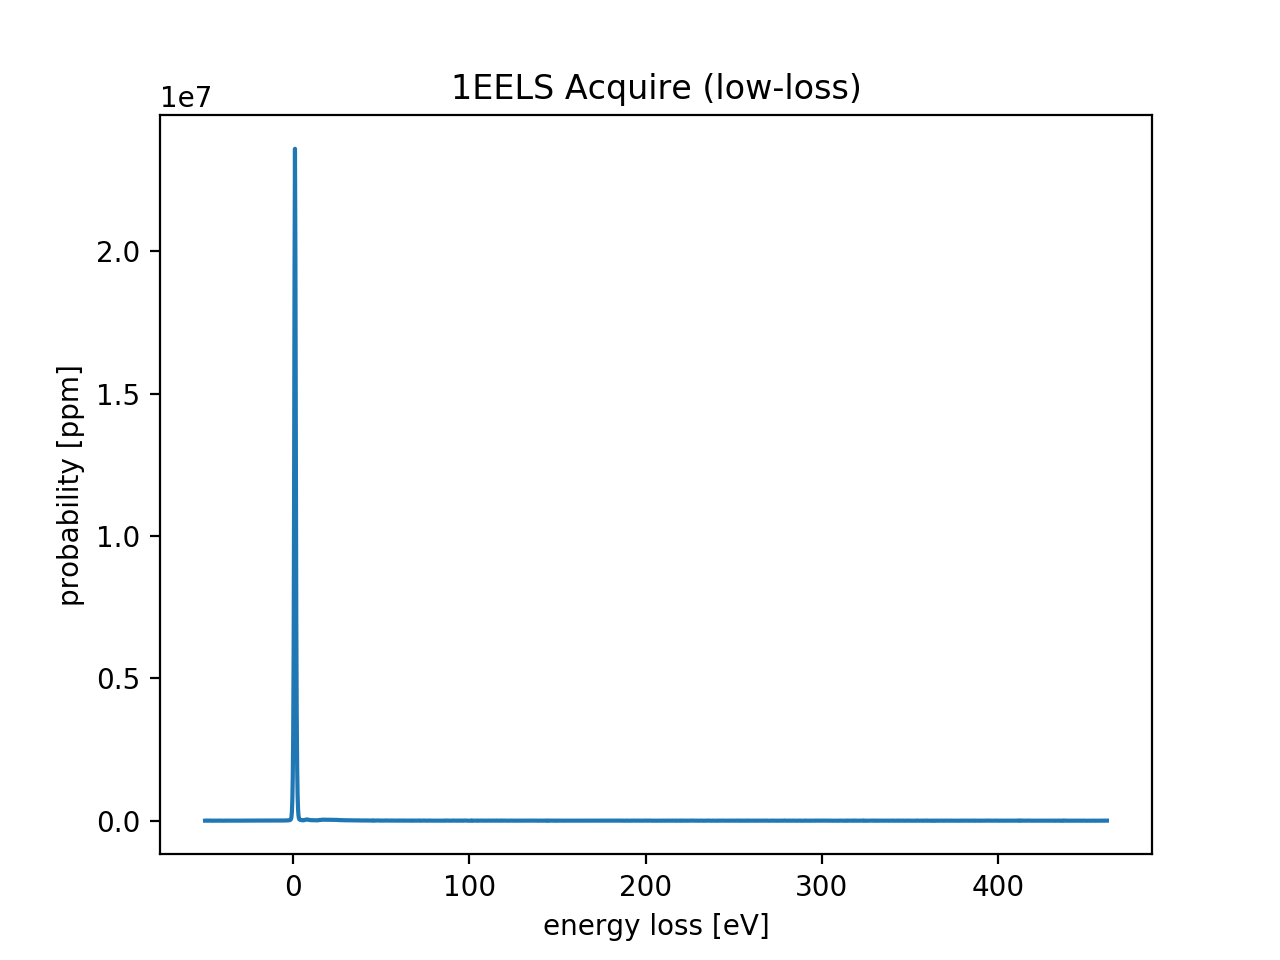

In [5]:
print(LLspectrum_tags.keys())

plt.figure()
plt.title(LLspectrum_tags['title'])
plt.plot(LLspectrum_tags['energy_scale'] , LLspectrum_tags['data'] );
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

115700152 counts in  0.21sec
integration time for spectrum was 63.00 s 
incident beam current of core--loss is 34710045600 counts


<IPython.core.display.Javascript object>


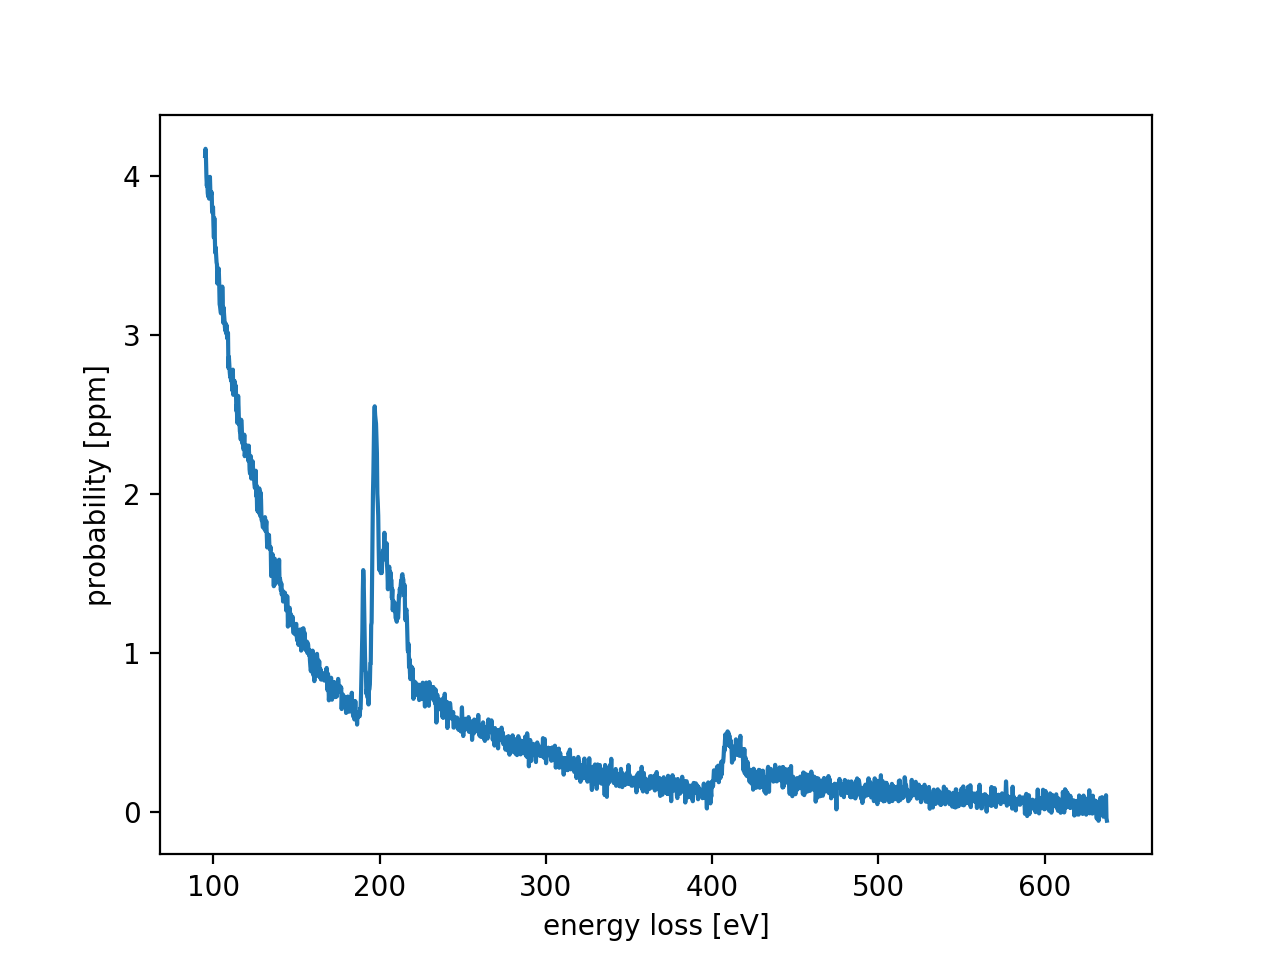

In [38]:
print(f"{LLspectrum_tags['data'].sum():.0f} counts in  {LLspectrum_tags['integration_time']:.2f}sec")
I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']
print(f"integration time for spectrum was {tags['integration_time']:.2f} s ")

I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']*tags['integration_time']
print(f"incident beam current of core--loss is {I0:.0f} counts")

if 'incident_beam_current_counts' in current_channel:
    current_channel['incident_beam_current_counts'][()] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['incident_beam_current_counts'] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']

spectrum = tags['data']*tags['intentsity_scale_ppm']
plt.figure()
plt.plot(tags['energy_scale'], spectrum)
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Components of a core loss spectrum

-background

-absorption edges

## Plotting of cross sections and spectrum
please note that spectrum and cross sections are not on the same scale

<IPython.core.display.Javascript object>


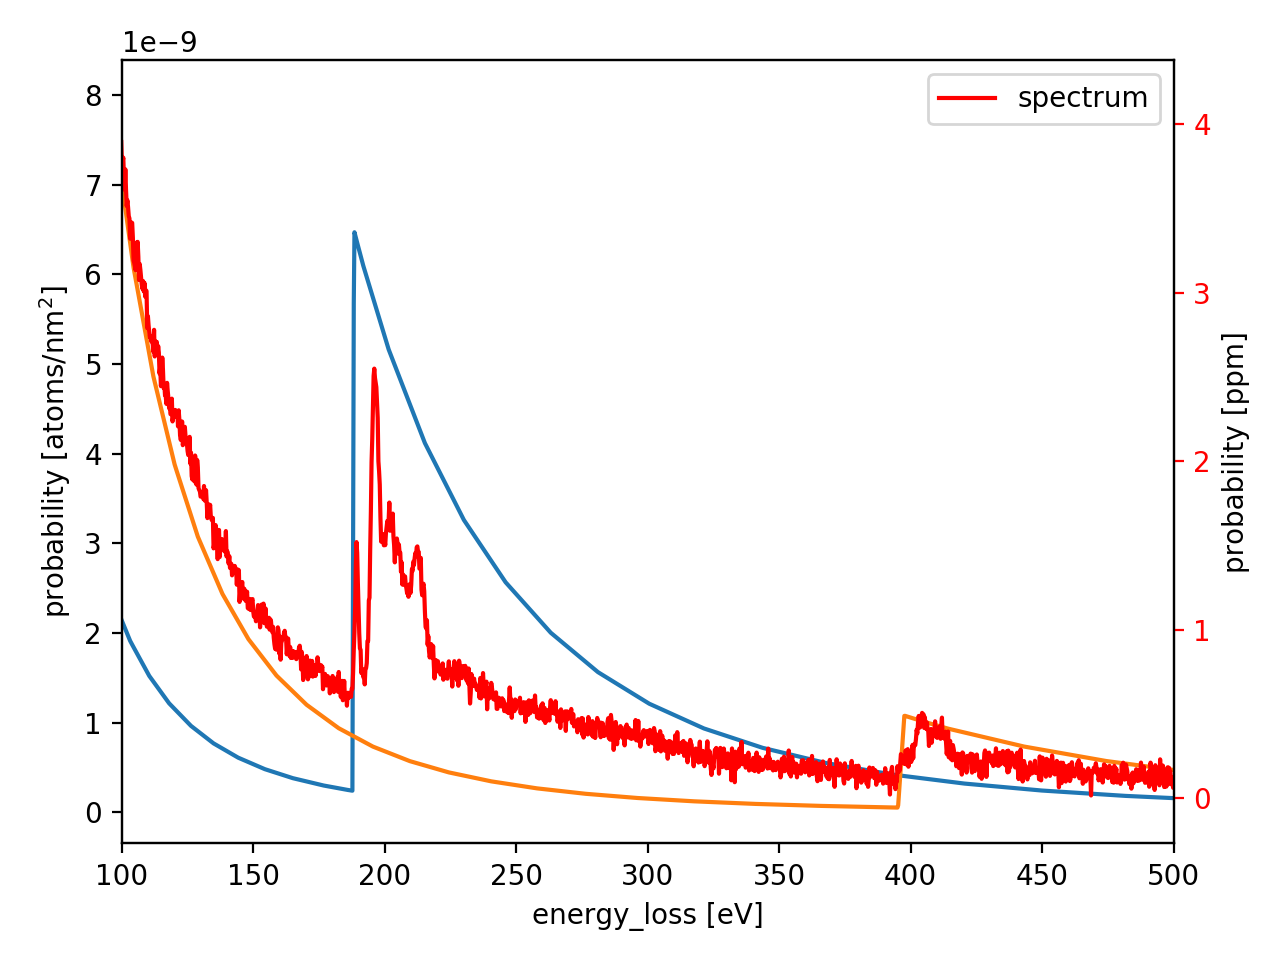

In [7]:
#energy_scale = energy_scale_orig*1.04-8

B_Xsection = eels.xsecXRPA(tags['energy_scale'], 200, 5, 10. )/1e10  
N_Xsection = eels.xsecXRPA(tags['energy_scale'], 200, 7, 10. ,shift=-6)/1e10       #  xsec  is in barns = 10^28 m2 = 10^10 nm2

fig, ax1 = plt.subplots()

ax1.plot(tags['energy_scale'], B_Xsection, label='B X-section' )
ax1.plot(tags['energy_scale'], N_Xsection, label='N X-section' )
ax1.set_xlabel('energy_loss [eV]')
ax1.set_ylabel('probability [atoms/nm$^{2}$]')

ax2 = ax1.twinx()
ax2.plot(tags['energy_scale'], spectrum, c='r', label='spectrum')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('probability [ppm]')
plt.xlim(100,500)
plt.legend();
fig.tight_layout();

## Background
The other ingredient in a core loss spetrum is the background

The backgrund consists of
- ionization edges to the left of the beginning of the spectrum (offset)
- tail of the plasmon peak (generally a power_law with $\approx A* E^{-3}$)

Here we approximate the background in an energy window before the first ionization edge in the spectrum as a power law with exponent $r\approx 3$

Power-law background with amplitude A: 12716933.6 and exponent -r: 3.24


<IPython.core.display.Javascript object>


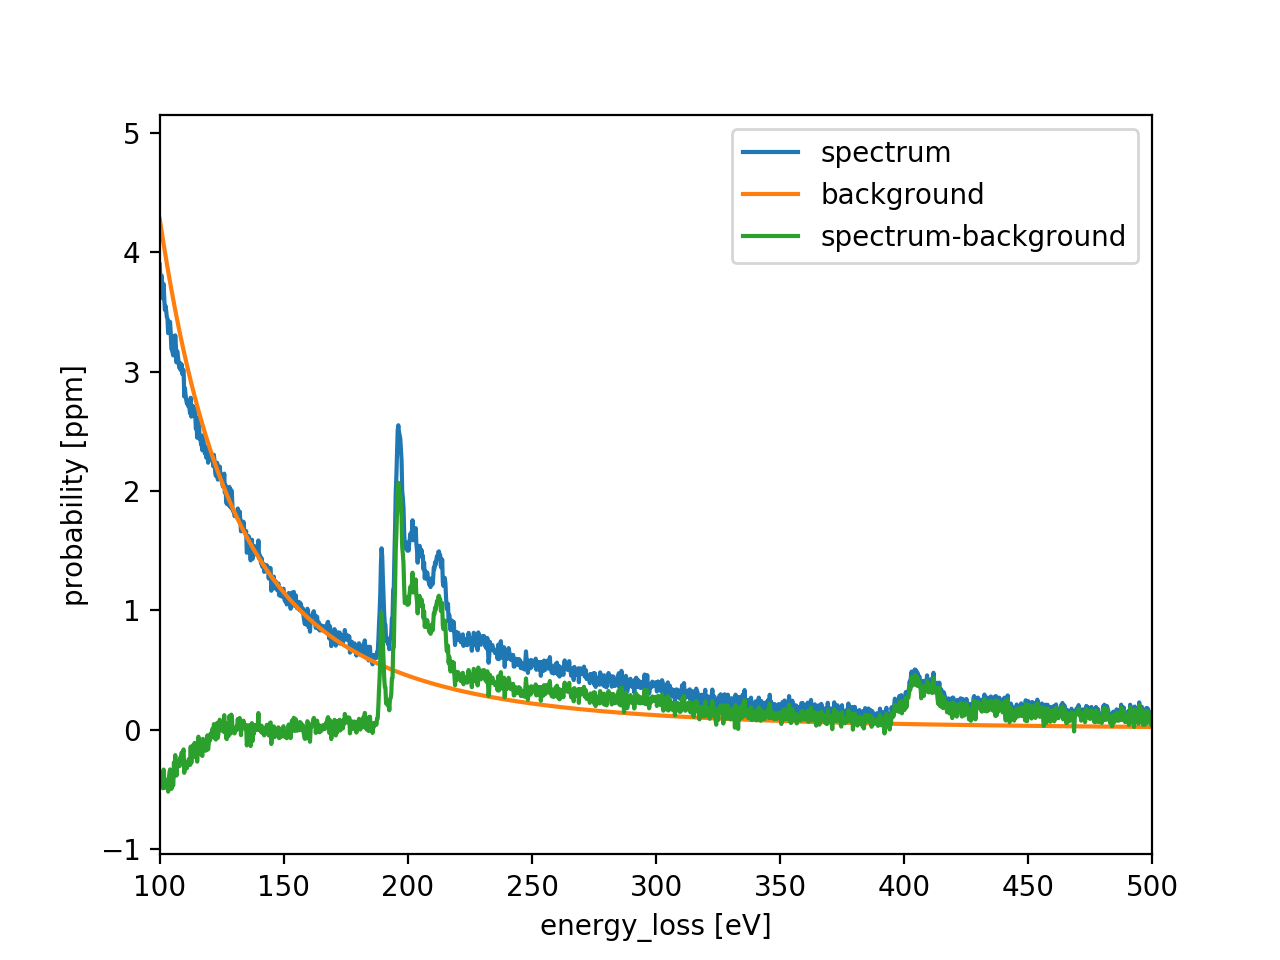

In [8]:
from scipy.optimize import leastsq  ## leastsqure fitting routine fo scipy

energy_scale = tags['energy_scale']
# Determine energy window in pixels
bgdStart = 120
bgdWidth = 30
offset = energy_scale[0]
dispersion = energy_scale[1]-energy_scale[0]
startx = int((bgdStart-offset)/dispersion)
endx = startx + int(bgdWidth/dispersion) 

x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

# Initial values of parameters
p0 = np.array([1.0E+20,3])

## background fitting 
def bgdfit(p, y, x):
    err = y - (p[0]* np.power(x,(-p[1])))
    return err
p, lsq = leastsq(bgdfit, p0, args=(y, x), maxfev=2000)
print(f'Power-law background with amplitude A: {p[0]:.1f} and exponent -r: {p[1]:.2f}')

#Calculate background over the whole energy scale
background = p[0]* np.power(energy_scale,(-p[1]))

plt.figure()

plt.xlabel('energy_loss [eV]')
plt.ylabel('probability [ppm]')

plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, background, label='background')
plt.plot(energy_scale, spectrum-background, label='spectrum-background')
plt.xlim(100,500)
plt.legend();


## Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

{'filename': 'B.K1', 'excl before': 5, 'excl after': 50, 'onset': 188.0, 'factor': 1.0, 'shape': 'hydrogenic'}
{'filename': 'N.K1', 'excl before': 5, 'excl after': 50, 'onset': 401.6, 'factor': 1.0, 'shape': 'hydrogenic'}


<IPython.core.display.Javascript object>


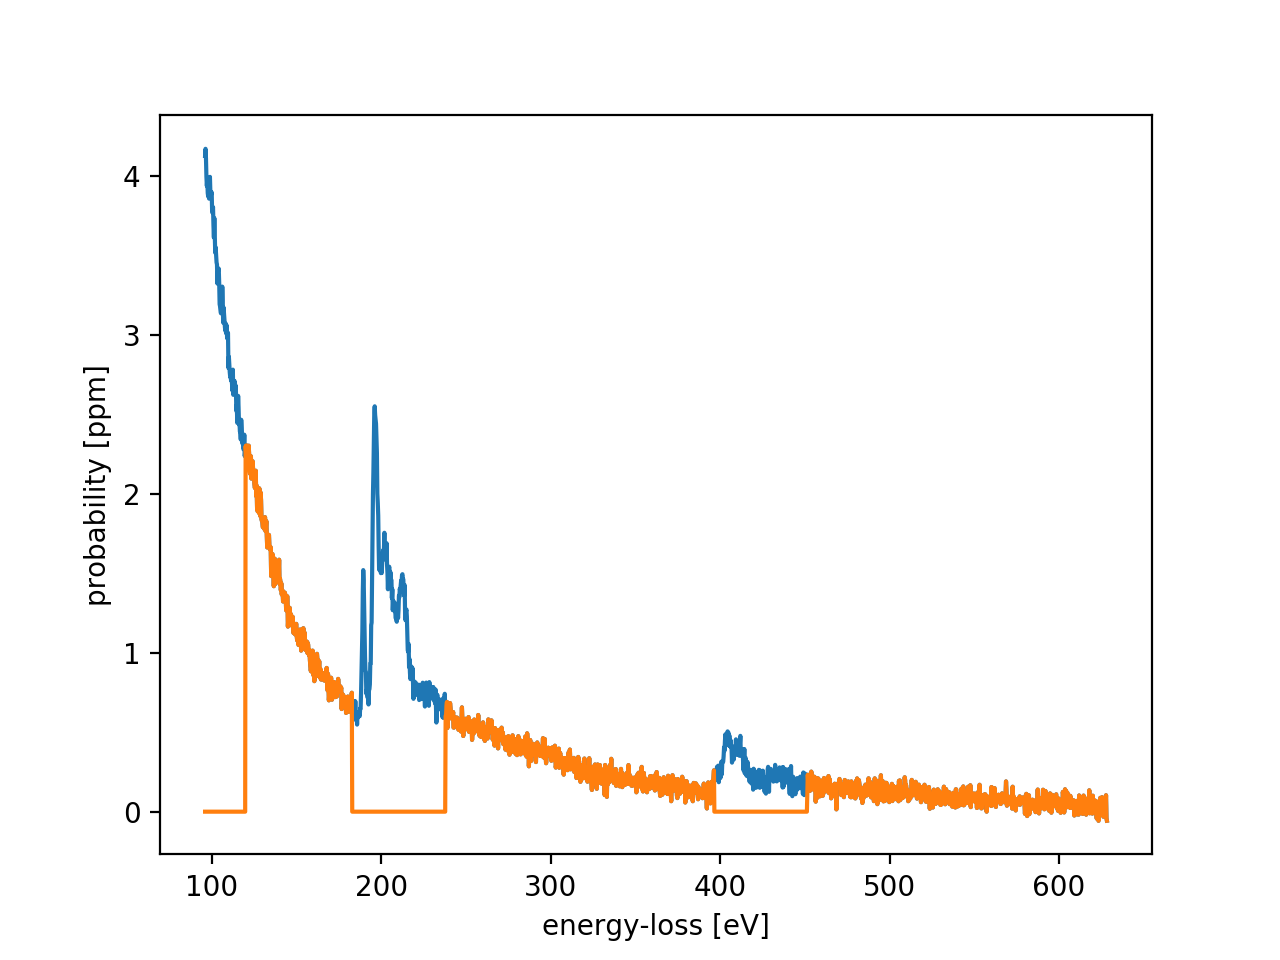

In [9]:
startx = int((bgdStart-offset)/dispersion)

mask = np.ones(len(energy_scale))
mask[0 : int(startx)] = 0.0;

edges = {}
edges['1'] = {}
edges['1']['Z']=5
edges['1']['symmetry']= 'K1'
edges['2'] = {}
edges['2']['Z']=7
edges['2']['symmetry']= 'K1'

for key in edges:
    print((eels.get_Xsections(edges[key]['Z']))[edges[key]['symmetry']])
    edges[key]['onset'] = (eels.get_Xsections(edges[key]['Z']))[edges[key]['symmetry']]['onset']
    edges[key]['onset_pixel'] = int((edges[key]['onset'] -offset)/dispersion)
    edges[key]['start_exclude'] = int((edges[key]['onset']-5  - offset)/dispersion)
    edges[key]['end_exclude']   = int((edges[key]['onset']+50 - offset)/dispersion)
    mask[edges[key]['start_exclude']:edges[key]['end_exclude']] = 0.0

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

## The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.



<IPython.core.display.Javascript object>


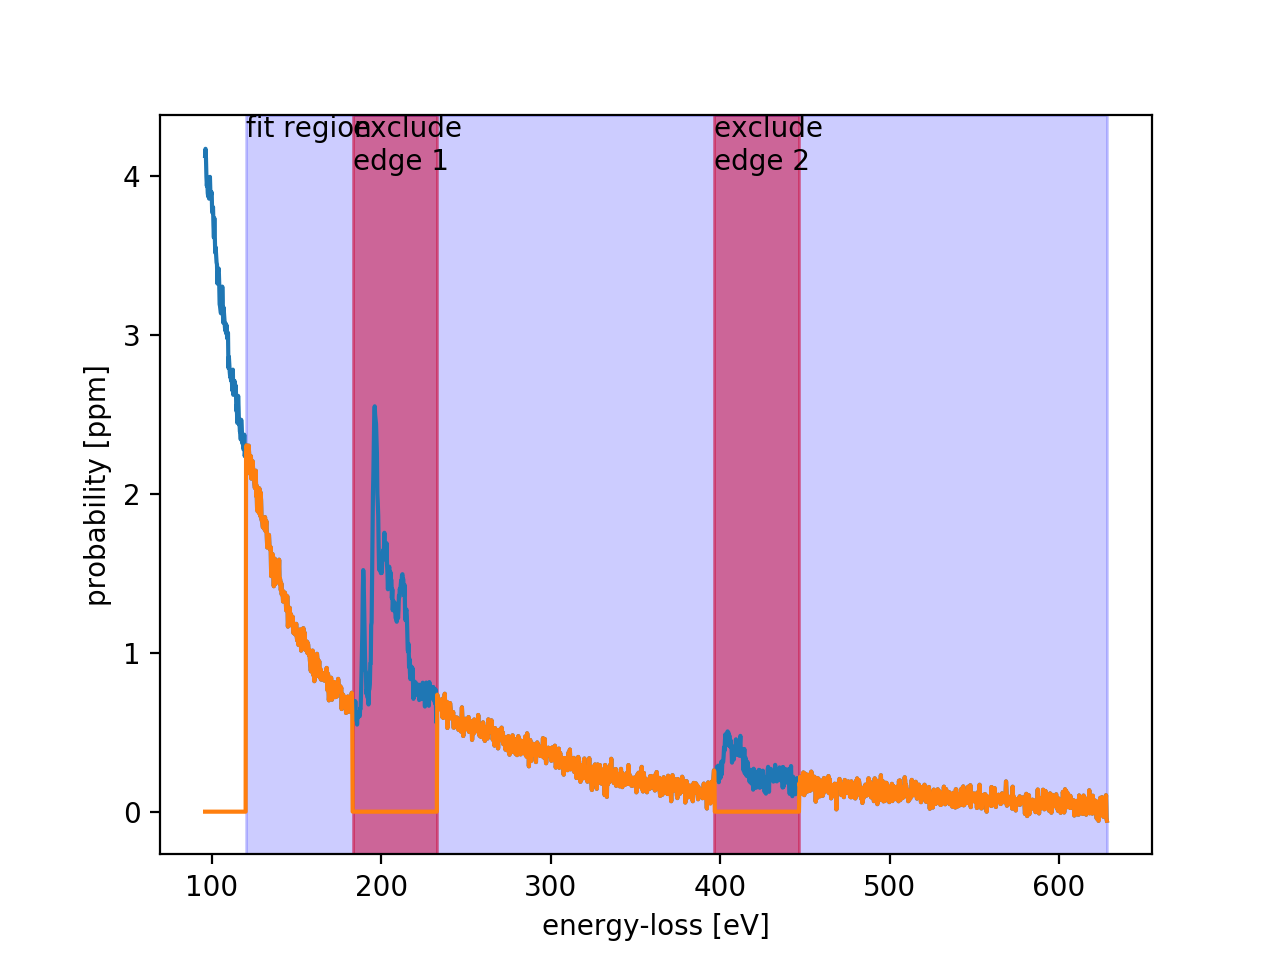

In [32]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = eels.Region_Selector(plt.gca())

for key in edges:
    regions.set_regions(str(key),edges[key]['onset']-5, 50.)
                                  
regions.set_regions('fit region',bgdStart, tags['energy_scale'][-1]-bgdStart)

In [15]:
region_tags = regions.get_regions()
startx = int((regions_tags['fit_region']['startx']-offset)/dispersion)

np.
print(region_tags)

{'1': {'start_x': 182.1495261471656, 'width_x': 48.39339112903224}, '2': {'start_x': 387.52635679232685, 'width_x': 48.39339112903224}, 'fit_area': {'start_x': 120, 'width_x': 508.22}}


In [30]:
region_tags = regions.get_regions()

mask = np.ones(tags['data'].shape)

#startx = np.searchsorted(tags['energy_scale'],region_tags['fit_area']['start_x'])
                            
mask[0:startx] = 0.0

for key in region_tags:
    end = region_tags[key]['start_x']+region_tags[key]['width_x']
    startx = np.searchsorted(tags['energy_scale'],region_tags[key]['start_x'])
    endx   = np.searchsorted(tags['energy_scale'],end)
    if key == 'fit_area':
        mask[0:startx] = 0.0
        mask[endx:-1] = 0.0
    else:
        mask[startx:endx] = 0.0



pin = np.array([1.0,1.0,.0,0.0,0.0,0.0, 1.0,1.0,0.001,5,3])
x = energy_scale

blurred = gaussian_filter(spectrum, sigma=5)

y = blurred*1e-6 ## now in probability
y[np.where(y<1e-8)]=1e-8

xsec = np.array([B_Xsection, N_Xsection])
numberOfEdges = 2

def residuals(p,  x, y ):
    err = (y-model(x,p))*mask/np.sqrt(np.abs(y))
    return err        

def model(x, p):  
    y = (p[9]* np.power(x,(-p[10]))) +p[7]*x+p[8]*x*x
    for i in range(numberOfEdges):
        y = y + p[i] * xsec[i,:]
    return y

p, cov = leastsq(residuals, pin,  args = (x,y) )
 
print(f"B/N ratio is {p[0]/p[1]:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
print(f" B areal density is {p[0]:.0f} atoms per square nm, which equates {abs(p[0])/18.2:.1f} atomic layers")
print(f" N areal density is {p[1]:.0f} atoms per square nm, which equates {abs(p[1])/18.2:.1f} atomic layers")



B/N ratio is 0.995
 B areal density is 136 atoms per square nm, which equates 7.5 atomic layers
 N areal density is 137 atoms per square nm, which equates 7.5 atomic layers


## Plotting of the fit


<IPython.core.display.Javascript object>


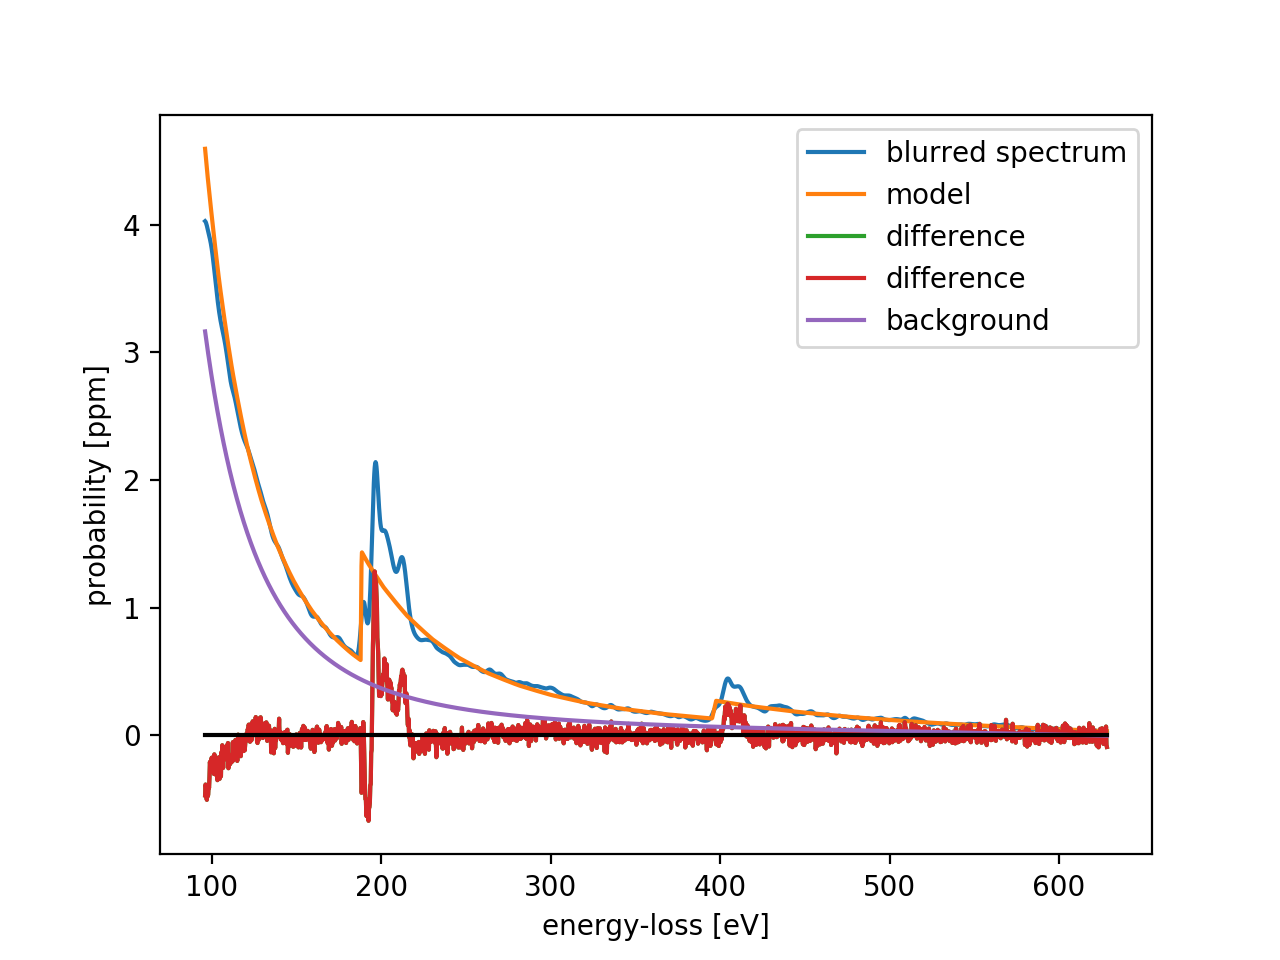

In [31]:
model_spectrum =  model(x, p)*1e6 # in ppm
model_background =  ((p[9]* np.power(x,-p[10])) +p[7]*x+p[8]*x*x)*1e6 # in ppm

plt.figure()
#plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, blurred, label='blurred spectrum')
plt.plot(x,model_spectrum, label='model')
plt.plot(x,spectrum-model_spectrum, label='difference')
plt.plot(x,(spectrum-model_spectrum), label='difference')
plt.plot(x,model_background, label='background')
plt.plot([x[0],x[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

## Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)
## Next:  [ELNES](ELNES.ipynb)

## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)